<a href="https://colab.research.google.com/github/kaspergroenbek98/first-first-year-project/blob/master/chaosBook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/kaspergroenbek98/first-first-year-project.git
### All import calls.
import numpy as np
import nltk
import csv
import nltk
import re
from collections import Counter
import pandas as pd
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt

fatal: destination path 'first-first-year-project' already exists and is not an empty directory.


In [0]:
### Functions

### START OF VOCABULARY ###
def generate_vocabulary(data, fCol, vocabType):
    '''
    Returns a list/vocabulary of len <= "size" based on the vocabType and the featureColumn specified
    '''
    size = 2000
    # Only get large groups to get representative data
    major_features = np.array(nltk.FreqDist(data[:,fCol]).most_common(5))
    major_masks = np.array([data[:,fCol] == f for (f, cnt) in major_features])
    fqs = [tweet_word_distribution(data[mask,:]) for mask in major_masks]
    return list(vocabType(data, fCol, major_features, major_masks, fqs, size))

def vocab_feature_most_common(data, fCol, major_features, major_masks, fqs, size):
    '''
    Returns a vocabulary checklist for each tweet to check off (True/False).
    Prioritises the most common words for each feature
    '''
    vocabulary = set()
    # get the most common words in each freq dist. zip(*...) removes the counts from fd, and updates vocabulary ONLY with the words
    for fd in fqs:
        vocabulary.update(list(zip(*fd.most_common(size//len(major_features))))[0])
    return vocabulary

def vocab_feature_unique(data, fCol, major_features, major_masks, fqs, size):
    '''
    Returns a vocabulary checklist for each tweet to check off (True/False).
    Prioritises words which are uncommon in other features, but common in one feature
    '''
    major_mask = np.array(major_masks.sum(axis=0), dtype='bool')
    fq = tweet_word_distribution(data[major_mask,:]) # Get a fq over the words used by all in the major categories
    words = [word for (word, cnt) in fq.items() if cnt >= 20] # removes rarely mentioned words which probably arent indicative of a significant trend
    priorityArray = []
    for i, word in enumerate(words):
        priorityArray.append([word])
        #divide frequency of word in that state by the tweetcount from that state, and by how often that word is used in total by all states
        score = max(fqs[fID][word]/(int(major_features[fID][1])*fq[word]) for fID in range(len(major_masks)))
        priorityArray[i].append(score)
    priorityArray.sort(key = lambda x: x[1], reverse=True) # Sort them based on their best score
    vocabulary = list(zip(*priorityArray[:size]))[0] # Removes their scores
    return vocabulary
### END OF VOCABULARY ###
    
def identify_hashtags(data):
    col = np.zeros((data.shape[0],1), 'str')
    data = np.append(data, col, axis=1)
    for i, text in enumerate(data[:,6]):
        results = re.findall(r"#\w+", text) # Finds matches and returns them as an iterable
        if results:
            data[i,15] = ' '.join(results)
        else:
            data[i,15] = ''

def tweet_features(tweet, word_features):
    tweet_words = set(tweet)
    features = {}
    for word in word_features:
        features[f'contains({word})'] = (word in tweet_words)
    return features

def divide_featureset(feature):
    '''
    Divides numpy featureset of (featureVector, classification) into a 80:10:10 train:dev:test set
    '''
    testSize = int(len(feature)*0.8)
    train, rest = feature[:testSize], feature[testSize:]
    restSize = len(rest)//2
    dev, test = rest[:restSize], rest[restSize:]
    return train, dev, test

#RegEx cleaner for SKlearn (Maybe merge with Clean()).
def cleaner(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('b4', 'before', text)
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub('https?://[A-Za-z0-9./]+','', text)
    text = text.strip(' ')
    return text

def clean(data):
    porter = nltk.PorterStemmer()

    # Remove all stopwords, non-alphabet words (except spaces), and stem the words
    for i, row in enumerate(data[:,6]):
        row = row.lower()
        row = ''.join(char for char in row if char.isalpha() or char == ' ')
        row = ' '.join(porter.stem(word) for word in row.split() if word not in stopwords)
        data[i,6] = row

def tweet_word_distribution(data):
    # Split each sentence into tokens, and create a frequency distribution
    tokens = [token for sentence in data[:,6] for token in sentence.split()]
    fd = nltk.FreqDist(tokens)
    return fd

def generate_features(data, vocabulary, fCol):
    """ 
    Creates tuples with a vector containing boolean values depending on whether
    or not the word is in the tweet - along with the label of the tweet.
    """
    features = [(tweet_features(d.split(), vocabulary), c) for (d,c) in zip(data[:,6], data[:,fCol])] # column 6 is text data, column 2 is gender data
    return features

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# Read the data into a header and a data np.array - the array is then shuffled
with open('first-first-year-project/data.csv', encoding='ISO-8859-1') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    data = np.array([np.array(line) for line in csv_reader])
header, data = data[0,:], data[1:,:]
np.random.shuffle(data)
print(header)

# Identify hashtags and insert them in the 15th column
identify_hashtags(data)
print(data.shape) # Note that shape starts at 1 and ends at 16, so the interval is [0:15]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['other_topic' 'resolution_topics' 'gender' 'name' 'Resolution_Category'
 'retweet_count' 'text' 'tweet_coord' 'tweet_created' 'tweet_date'
 'tweet_id' 'tweet_location' 'tweet_state' 'user_timezone' 'tweet_region']
(5011, 15)


In [0]:
clean(data)
fCol = {'gender':2, 'Resolution_Category':4, 'tweet_state':12, 'hashtags':15} # Dont think hashtags work right now
vocabType = [vocab_feature_most_common, vocab_feature_unique][0] #Pick one by replacing the number in [int]
vocabulary =         generate_vocabulary(data, fCol['tweet_state'], vocabType)
features = generate_features(data, vocabulary, fCol['tweet_state'])
train, dev, test = divide_featureset(features)

In [5]:
classifier = nltk.NaiveBayesClassifier.train(train)
print(nltk.classify.accuracy(classifier, dev))
classifier.show_most_informative_features(10)

0.12574850299401197
Most Informative Features
          contains(quit) = True               ND : CA     =    196.3 : 1.0
        contains(chocol) = True               DE : CA     =    147.2 : 1.0
          contains(babi) = True               ND : NY     =    146.7 : 1.0
      contains(cariloha) = True               DE : NY     =    110.0 : 1.0
          contains(loos) = True               DE : NY     =    110.0 : 1.0
 contains(mlbpaclubhous) = True               ND : TX     =    100.7 : 1.0
          contains(date) = True               MT : CA     =     98.2 : 1.0
         contains(catch) = True               MT : CA     =     98.2 : 1.0
      contains(mcdonald) = True               MT : CA     =     98.2 : 1.0
          contains(step) = True               DE : CA     =     88.3 : 1.0


# Bad Word Implementation

In [0]:
import pandas as pd
import itertools
clean(data)
np.random.shuffle(data)

In [0]:
bad_words_txt = pd.read_csv('first-first-year-project/bad-words.txt', sep='\n',)
bad_words_array = bad_words_txt.to_numpy()
bad_words_list = bad_words_array.tolist()
bad_words = list(itertools.chain(*bad_words_list))

In [0]:
tweets_created = list(data[:,8])
dates = [i.split(' ',1)[0] for i in tweets_created]
times = [i.split(' ',1)[-1] for i in tweets_created]

In [0]:
fCol = {'gender':2, 'Resolution_Category':4, 'tweet_created':8, 'tweet_state':12, 'tweet_region':14, 'hashtags':15}

## Bad words and Gender

In [0]:
features2 = generate_features(data, bad_words, fCol['gender'])
train2, dev2, test2 = divide_featureset(features2)

In [11]:
classifier2 = nltk.NaiveBayesClassifier.train(train2)
print(nltk.classify.accuracy(classifier2, dev2))
classifier2.show_most_informative_features(15)

0.48902195608782434
Most Informative Features
          contains(dick) = True           female : male   =      4.4 : 1.0
          contains(butt) = True             male : female =      4.3 : 1.0
         contains(adult) = True           female : male   =      3.7 : 1.0
         contains(fight) = True             male : female =      3.4 : 1.0
          contains(kill) = True             male : female =      3.4 : 1.0
          contains(burn) = True           female : male   =      3.0 : 1.0
        contains(christ) = True           female : male   =      3.0 : 1.0
           contains(fat) = True             male : female =      2.8 : 1.0
          contains(damn) = True             male : female =      2.5 : 1.0
          contains(boob) = True           female : male   =      2.3 : 1.0
          contains(poop) = True             male : female =      2.3 : 1.0
         contains(crack) = True             male : female =      2.3 : 1.0
          contains(cunt) = True             male : fem

## Bad words and Categories

In [12]:
features3 = generate_features(data, bad_words, fCol['Resolution_Category'])
train3, dev3, test3 = divide_featureset(features3)
classifier3 = nltk.NaiveBayesClassifier.train(train3)
print(nltk.classify.accuracy(classifier3, dev3))
classifier3.show_most_informative_features(10)

0.3652694610778443
Most Informative Features
       contains(swallow) = True           Educat : Person =     20.2 : 1.0
        contains(german) = True           Educat : Person =     20.2 : 1.0
         contains(nigga) = True           Career : Person =     14.5 : 1.0
         contains(shoot) = True           Career : Person =     14.5 : 1.0
         contains(color) = True           Time M : Person =     12.7 : 1.0
          contains(damn) = True           Philan : Person =     12.1 : 1.0
           contains(god) = True           Person : Humor  =      9.9 : 1.0
         contains(fight) = True           Philan : Health =      9.4 : 1.0
           contains(kid) = True           Philan : Health =      9.4 : 1.0
        contains(fucker) = True           Career : Humor  =      8.1 : 1.0


## Bad words and Regions

In [13]:
features4 = generate_features(data, bad_words, fCol['tweet_region'])
train4, dev4, test4 = divide_featureset(features4)
classifier4 = nltk.NaiveBayesClassifier.train(train4)
print(nltk.classify.accuracy(classifier4, dev4))
classifier4.show_most_informative_features(10)

0.32335329341317365
Most Informative Features
          contains(dick) = True           Midwes : South  =      5.7 : 1.0
        contains(harder) = True           Midwes : West   =      4.6 : 1.0
        contains(bigger) = True             West : South  =      4.5 : 1.0
           contains(die) = True             West : South  =      3.7 : 1.0
         contains(faith) = True           Midwes : South  =      3.4 : 1.0
          contains(burn) = True             West : Northe =      3.0 : 1.0
          contains(kill) = True            South : West   =      3.0 : 1.0
          contains(fear) = True           Midwes : West   =      2.9 : 1.0
          contains(shit) = True           Northe : South  =      2.9 : 1.0
           contains(kid) = True             West : South  =      2.6 : 1.0


## Bad words and Dates

In [14]:
#In progress: comparison of bad words and dates
features5 = generate_features(data, bad_words, dates) #Dates not working atm, gonna raise an error.
train5, dev5, test5 = divide_featureset(features5)
classifier5 = nltk.NaiveBayesClassifier.train(train5)
print(nltk.classify.accuracy(classifier5, dev5))
classifier5.show_most_informative_features(10)

IndexError: ignored

In [0]:
#In progress: creation of bad word bigrams 
tokens = [token for sentence in data[:,6] for token in sentence.split()]
bigrams2 = list(nltk.ngrams(tokens, 2))
fdbigrams2 = nltk.FreqDist(bigrams2)

#**K-Fold implementation** (WORKING!)

In [0]:
# Data preperations, set all the relevant labels here as done earlier
np.random.shuffle(data)
kf_fCol = {'gender':2, 'Resolution_Category':4, 'tweet_state':12, 'hashtags':15}
kf_vocabType = [vocab_feature_most_common, vocab_feature_unique][0] #Pick one by replacing the number in [int]
kf_vocabulary = generate_vocabulary(data, kf_fCol['gender'], kf_vocabType)
kf_features = generate_features(data, vocabulary, fCol['gender'])


#kf_features = kf_features[:500]  # Define the amount of data to use

In [17]:
# Import KFold model and define the amount of folds
from sklearn.model_selection import KFold  # import model
k = 5  # amount of folds

# Store an object of the KFold class in a variable with shuffle=True
kf = KFold(n_splits=k, shuffle=True)

""" 
Loop for the models and their designated folds (1 to k)
and calculate the average of each of the 'k' models' accuracy
using the NB classifier and k-fold model class.
"""
sum = 0 # sum to calculate average of model accuracies
iteration = 1
for train, test in kf.split(kf_features): # Loop over K chunk of data splits
    train_data = np.array(kf_features)[train] # New chunk of train data
    test_data = np.array(kf_features)[test] # New chunk of test data

    # Define the NB classifier to the train data
    kd_classifier = nltk.NaiveBayesClassifier.train(train_data)

    print("Iteration no.", iteration, "\n")
    print("Accuracy of iteration number", iteration, ":", nltk.classify.accuracy(kd_classifier, test_data))
    kd_classifier.show_most_informative_features(10)
    print("\n\n")

    sum += nltk.classify.accuracy(kd_classifier, test_data) # Add current sum to total

    iteration += 1 # Increment variable to display next iteration

# Average calculated by the sum divided by the number of folds
average = sum/k
print("The accuracy average of the K-fold models:", average)

Iteration no. 1 

Accuracy of iteration number 1 : 0.5992023928215354
Most Informative Features
      contains(cariloha) = True           female : male   =     16.1 : 1.0
contains(hashtagoftheweek) = True           female : male   =     13.5 : 1.0
          contains(miss) = True             male : female =      7.1 : 1.0
          contains(wife) = True             male : female =      5.8 : 1.0
        contains(youtub) = True             male : female =      5.8 : 1.0
        contains(chocol) = True           female : male   =      5.6 : 1.0
       contains(tixwish) = True           female : male   =      5.6 : 1.0
          contains(pick) = True           female : male   =      5.3 : 1.0
      contains(encourag) = True             male : female =      5.1 : 1.0
           contains(ima) = True             male : female =      5.1 : 1.0



Iteration no. 2 

Accuracy of iteration number 2 : 0.5748502994011976
Most Informative Features
      contains(cariloha) = True           female : ma

# NB in Sklearn and Pandas.

In [0]:
# Using pandas to load the data file into a CSV.
# ISO-8859-1 is the encoding for tweets.
df = pd.read_csv("first-first-year-project/data.csv", encoding = "ISO-8859-1")
#First step to cleaning the data, removing the categories we dont need.
panda_data = df.drop(["other_topic","resolution_topics", "tweet_coord", "tweet_created","tweet_id", "name", "retweet_count", "tweet_date", "user_timezone"], axis = 1)


#Cleaning all the text in our data with our newly build cleaner() function.
for i in range(len(panda_data.text)):
  panda_data.text[i] = cleaner(panda_data.text[i])

from sklearn.model_selection import train_test_split
#Splitting the data into train and test set. + shuffling while doing so. the test size is = 20%.
train, test = train_test_split(panda_data,train_size=0.8, test_size=0.2, shuffle=True)

In [23]:
#Using Sklearn, playing around with the CountVectorizer.
vectorizer = CountVectorizer(analyzer="word", stop_words= "english",min_df= 1, binary= True)
#Create vectorized train set
X_train = vectorizer.fit_transform(train.text)
X_train.toarray()
#Create vectorized test set
X_test = vectorizer.transform(test.text)
X_test.toarray()
print(vectorizer.get_feature_names())
# print(vectorizer.vocabulary_.get(u"newyearsresolution"))
# print(X_train.toarray())
# print(X_train.shape)

['000', '01', '015', '02am', '03', '03govidp0m', '04', '050', '0dzlrttkc8', '0fip12rofa', '0fpxxkiery', '0fwwwgfvbp', '0hgb0l1ffk', '0i30qcidc0', '0wdvtmx7u2', '10', '100', '1000', '100lbs', '1024', '1080', '1080i', '1080p', '10am', '10k', '10lbs', '10x', '11', '110', '110lbs', '117th', '11am', '12', '120', '120sports', '127243', '1280', '1280x1600', '12atzvlgtq', '12days', '12o', '13', '13_roach', '14', '1440', '1485', '15', '150', '157143', '159', '15k', '15lbs', '15poundstogo', '15th', '16', '165', '17', '18', '180', '1800', '19', '190', '1920', '1920x1080', '19376316819', '195lbs', '1967boldwriter', '1969', '1985', '1996', '1998', '1999', '1and0', '1d', '1for1', '1k', '1lpm3buqg5', '1oaaq0nx0t', '1problem', '1st', '1tlayg0ura', '1u', '1z48gumjph', '1zderlt0zl', '1zhfih0xwd', '20', '200', '2000', '2009', '200dayswithoutrayban', '200lbs', '2013', '2014', '2014memories', '2015', '2015goals', '2015gonnabemyyear', '2015herewecome', '2015ready', '2015resolutions', '2015rocks', '2015willb

In [24]:
#Here we use term frequency to downscale the importance of words occuring many times in a tweet. That way we hopefully get more weighted words. 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
print(X_train_tfidf.shape)
X_test_tfidf = tfidf_transformer.fit_transform(X_test)
print(X_test_tfidf.shape)

(4008, 8054)
(1003, 8054)


In [27]:
#Accuracy without using term frequency.
NBmodel = MultinomialNB().fit(X_train, train.Resolution_Category)
predicted_1 = NBmodel.predict(X_test)
np.mean(predicted_1 == test.Resolution_Category)

#Accuracy using term frequency. (Odd that its lower, but we do have a small data set)
NBmodel = MultinomialNB().fit(X_train_tfidf, train.Resolution_Category)
predicted_2 = NBmodel.predict(X_test_tfidf)
np.mean(predicted_2 == test.Resolution_Category)

#A classification_report without term frequency. Right now its pretty trash.
print(metrics.classification_report(test.Resolution_Category, predicted_1))

                              precision    recall  f1-score   support

                      Career       0.00      0.00      0.00        15
          Education/Training       0.00      0.00      0.00        22
Family/Friends/Relationships       0.50      0.03      0.06        59
                     Finance       1.00      0.39      0.56        31
            Health & Fitness       0.63      0.50      0.56       173
                       Humor       0.49      0.21      0.30       210
             Personal Growth       0.44      0.92      0.59       354
               Philanthropic       1.00      0.06      0.11        18
        Recreation & Leisure       0.60      0.06      0.11        99
Time Management/Organization       0.00      0.00      0.00        22

                    accuracy                           0.48      1003
                   macro avg       0.47      0.22      0.23      1003
                weighted avg       0.50      0.48      0.40      1003



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
#just creating a list of the different categories in the "Resolution_Category" column.
categories = list()
for i in test.Resolution_Category:
  if i in categories:
    pass
  else:
    categories.append(i)

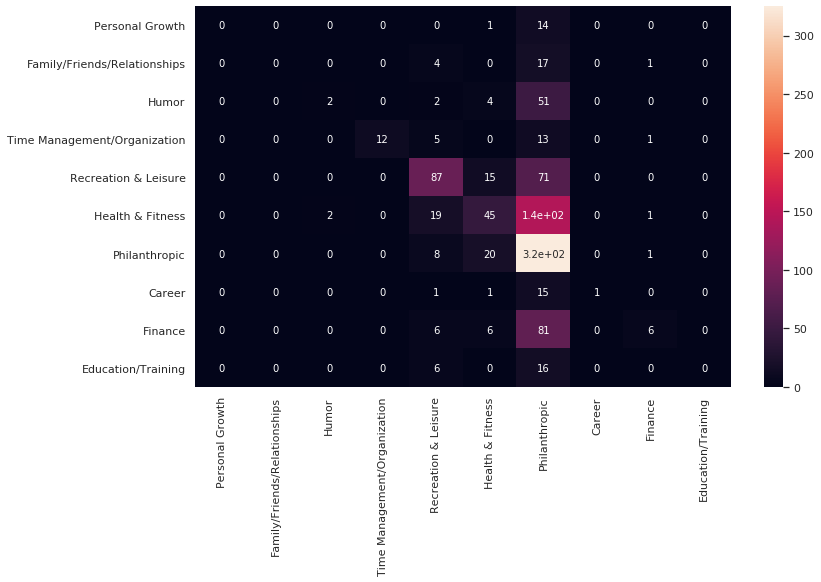

In [29]:
# A nice confusion matrix using seaborn.
array = metrics.confusion_matrix(test.Resolution_Category, predicted_1)
plt.figure(figsize=(12,7))
sn.set(font_scale=1) # for x/y label size
sn.heatmap(array, annot=True, annot_kws={"size": 10}, xticklabels = categories, yticklabels = categories) # annot_kws is the size of the numbers.
plt.show()